In [131]:
! pip install pylatexenc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [132]:
! pip install "git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qiskit-community/qiskit-textbook.git to /tmp/pip-req-build-k9eyof8v
  Running command git clone --filter=blob:none --quiet https://github.com/qiskit-community/qiskit-textbook.git /tmp/pip-req-build-k9eyof8v
  Resolved https://github.com/qiskit-community/qiskit-textbook.git to commit 272a3f92ef25079e4f0a4ef174bbbe439cc64fe8
  Preparing metadata (setup.py) ... done


In [72]:
from qiskit import IBMQ, assemble, transpile
from qiskit.tools.monitor import job_monitor

In [73]:
TOKEN="5c68361d5b9e2c398434de7d981228d3556831658cded8c26a033c8ac53da6315d5323659c57a779fe4630f4fd9d3104ad65483f905c39767a8c8d30caa5a94f"
IBMQ.save_account(TOKEN)
IBMQ.load_account() # Load account from disk
# IBMQ.providers() 

configrc.store_credentials:WARNING:2023-03-10 09:13:35,490: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2023-03-10 09:13:35,715: Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [74]:
from qiskit import *
from qiskit.providers.aer import AerSimulator

In [75]:
from qiskit import QuantumRegister, ClassicalRegister, Aer, BasicAer, QuantumCircuit, execute
from qiskit.visualization import plot_histogram
from qiskit.providers.aer import QasmSimulator,StatevectorSimulator
from qiskit.visualization import plot_state_city,circuit_drawer
from qiskit.quantum_info import Statevector
import numpy as np

####Quantum Circuit for Encryption Algorithm of smallGIFT

In [133]:
def smallGIFT(block_size, key_size):
  qreg = QuantumRegister(block_size, 'q')
  circuit = QuantumCircuit(qreg, name="smallGIFT")

  #############First S-box#################
  circuit.ccx(qreg[0], qreg[2], qreg[1])
  circuit.ccx(qreg[3], qreg[1], qreg[0])
  circuit.x(qreg[0])
  circuit.x(qreg[1])
  circuit.ccx(qreg[0], qreg[1], qreg[2])
  circuit.x(qreg[0])
  circuit.x(qreg[1])
  circuit.x(qreg[2])
  circuit.cx(qreg[2], qreg[3])
  circuit.x(qreg[3])
  circuit.cx(qreg[3], qreg[1])
  circuit.x(qreg[1])
  circuit.ccx(qreg[0], qreg[1], qreg[2])
  circuit.swap(qreg[0],qreg[3])

  #############Second S-box#################
  circuit.ccx(qreg[4+0], qreg[4+2], qreg[4+1])
  circuit.ccx(qreg[4+3], qreg[4+1], qreg[4+0])
  circuit.x(qreg[4+0])
  circuit.x(qreg[4+1])
  circuit.ccx(qreg[4+0], qreg[4+1], qreg[4+2])
  circuit.x(qreg[4+0])
  circuit.x(qreg[4+1])
  circuit.x(qreg[4+2])
  circuit.cx(qreg[4+2], qreg[4+3])
  circuit.x(qreg[4+3])
  circuit.cx(qreg[4+3], qreg[4+1])
  circuit.x(qreg[4+1])
  circuit.ccx(qreg[4+0], qreg[4+1], qreg[4+2])
  circuit.swap(qreg[4+0],qreg[4+3])

  #############Permutation#################
  circuit.swap(qreg[1], qreg[3])
  circuit.swap(qreg[1], qreg[7])
  circuit.swap(qreg[2], qreg[5])
  circuit.swap(qreg[2], qreg[4])

  # #############Key Addition#################
  # circuit.cx(qreg[8],qreg[0])
  # circuit.cx(qreg[9],qreg[4])
  # circuit.cx(qreg[10],qreg[1])
  # circuit.cx(qreg[11],qreg[5])

  return circuit

# circuit_drawer(circuit, output='mpl')

#### oracle for creating distribution z= (x,F(x))  
where F() is the cipher

In [134]:
def oracle_smallGIFT(block_size):
  qreg = QuantumRegister((block_size)*2, 'q')
  offset=block_size
  circuit = QuantumCircuit(qreg, name="oracle_smallGIFT_distribution")

  for i in range(offset):
    circuit.h(i)
    circuit.cx(i,offset+i)

  circuit.append(smallGIFT(block_size, key_size),range(offset))

  return circuit
  # the circuit now is F(x), x

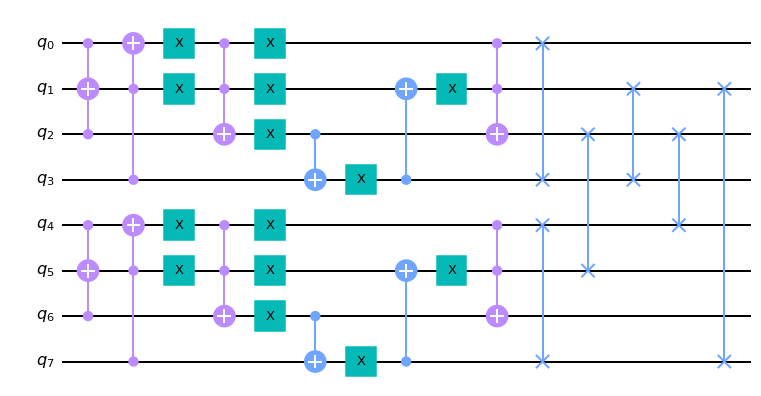

In [25]:
smallGIFT(8,4).draw(output="mpl")

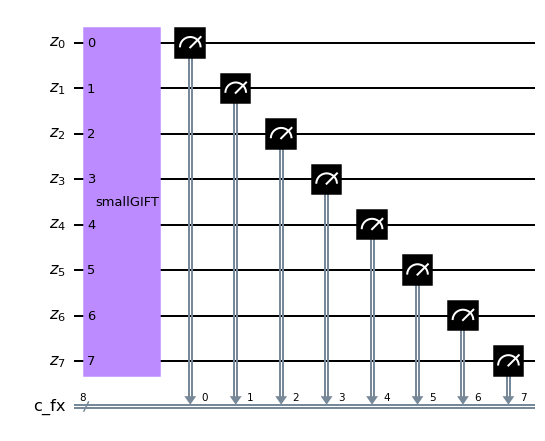

In [28]:
qreg_z = QuantumRegister(block_size, 'z') 
creg_c_fx = ClassicalRegister(block_size, 'c_fx')
circuit = QuantumCircuit(qreg_z, creg_c_fx)

# superposition over subspace of Z
circuit.append(smallGIFT(block_size, key_size),range(block_size))

# hadamard
# circuit.h(range(block_size*2))

circuit.measure(qreg_z[0:block_size], creg_c_fx)
# circuit_drawer(circuit, output='mpl')
circuit.decompose(gates_to_decompose='oracle_smallGIFT_distribution').draw(output='mpl')
# the structure now is.... |c> |F(x)> |x>

In [78]:
block_size = 8
key_size = 4
my_list = []

for i in range(0,256):
  qreg_z = QuantumRegister(block_size, 'z') 
  creg_c_fx = ClassicalRegister(block_size, 'c_fx')
  circuit = QuantumCircuit(qreg_z, creg_c_fx)

  if(i&1):
    circuit.x(0)
  if(i&2):
    circuit.x(1)
  if(i&4):
    circuit.x(2)
  if(i&8):
    circuit.x(3)
  if(i&16):
    circuit.x(4)
  if(i&32):
    circuit.x(5)
  if(i&64):
    circuit.x(6)
  if(i&128):
    circuit.x(7)

  circuit.append(smallGIFT(block_size, key_size),range(block_size))

  circuit.measure(qreg_z[0:block_size], creg_c_fx)

  simulator=Aer.get_backend('aer_simulator_matrix_product_state')
  tcirc = transpile(circuit, simulator)
  result = simulator.run(tcirc, shots=10).result()
  counts = result.get_counts(0)
  print(bin(i), counts)
  # print(i, int(list(counts.keys())[0], 2))
  my_list.append((i,int(list(counts.keys())[0], 2)))

0b0 {'00000101': 10}
0b1 {'10001100': 10}
0b10 {'00100100': 10}
0b11 {'10100100': 10}
0b100 {'00101100': 10}
0b101 {'10101101': 10}
0b110 {'00001101': 10}
0b111 {'10000101': 10}
0b1000 {'00001100': 10}
0b1001 {'10100101': 10}
0b1010 {'10001101': 10}
0b1011 {'00101101': 10}
0b1100 {'00100101': 10}
0b1101 {'00000100': 10}
0b1110 {'10000100': 10}
0b1111 {'10101100': 10}
0b10000 {'00010011': 10}
0b10001 {'10011010': 10}
0b10010 {'00110010': 10}
0b10011 {'10110010': 10}
0b10100 {'00111010': 10}
0b10101 {'10111011': 10}
0b10110 {'00011011': 10}
0b10111 {'10010011': 10}
0b11000 {'00011010': 10}
0b11001 {'10110011': 10}
0b11010 {'10011011': 10}
0b11011 {'00111011': 10}
0b11100 {'00110011': 10}
0b11101 {'00010010': 10}
0b11110 {'10010010': 10}
0b11111 {'10111010': 10}
0b100000 {'01000001': 10}
0b100001 {'11001000': 10}
0b100010 {'01100000': 10}
0b100011 {'11100000': 10}
0b100100 {'01101000': 10}
0b100101 {'11101001': 10}
0b100110 {'01001001': 10}
0b100111 {'11000001': 10}
0b101000 {'01001000': 

In [ ]:
# my_list

In [ ]:
# my_list.sort(key = lambda x: x[1])
# my_list

In [135]:
block_size = 8
key_size = 4

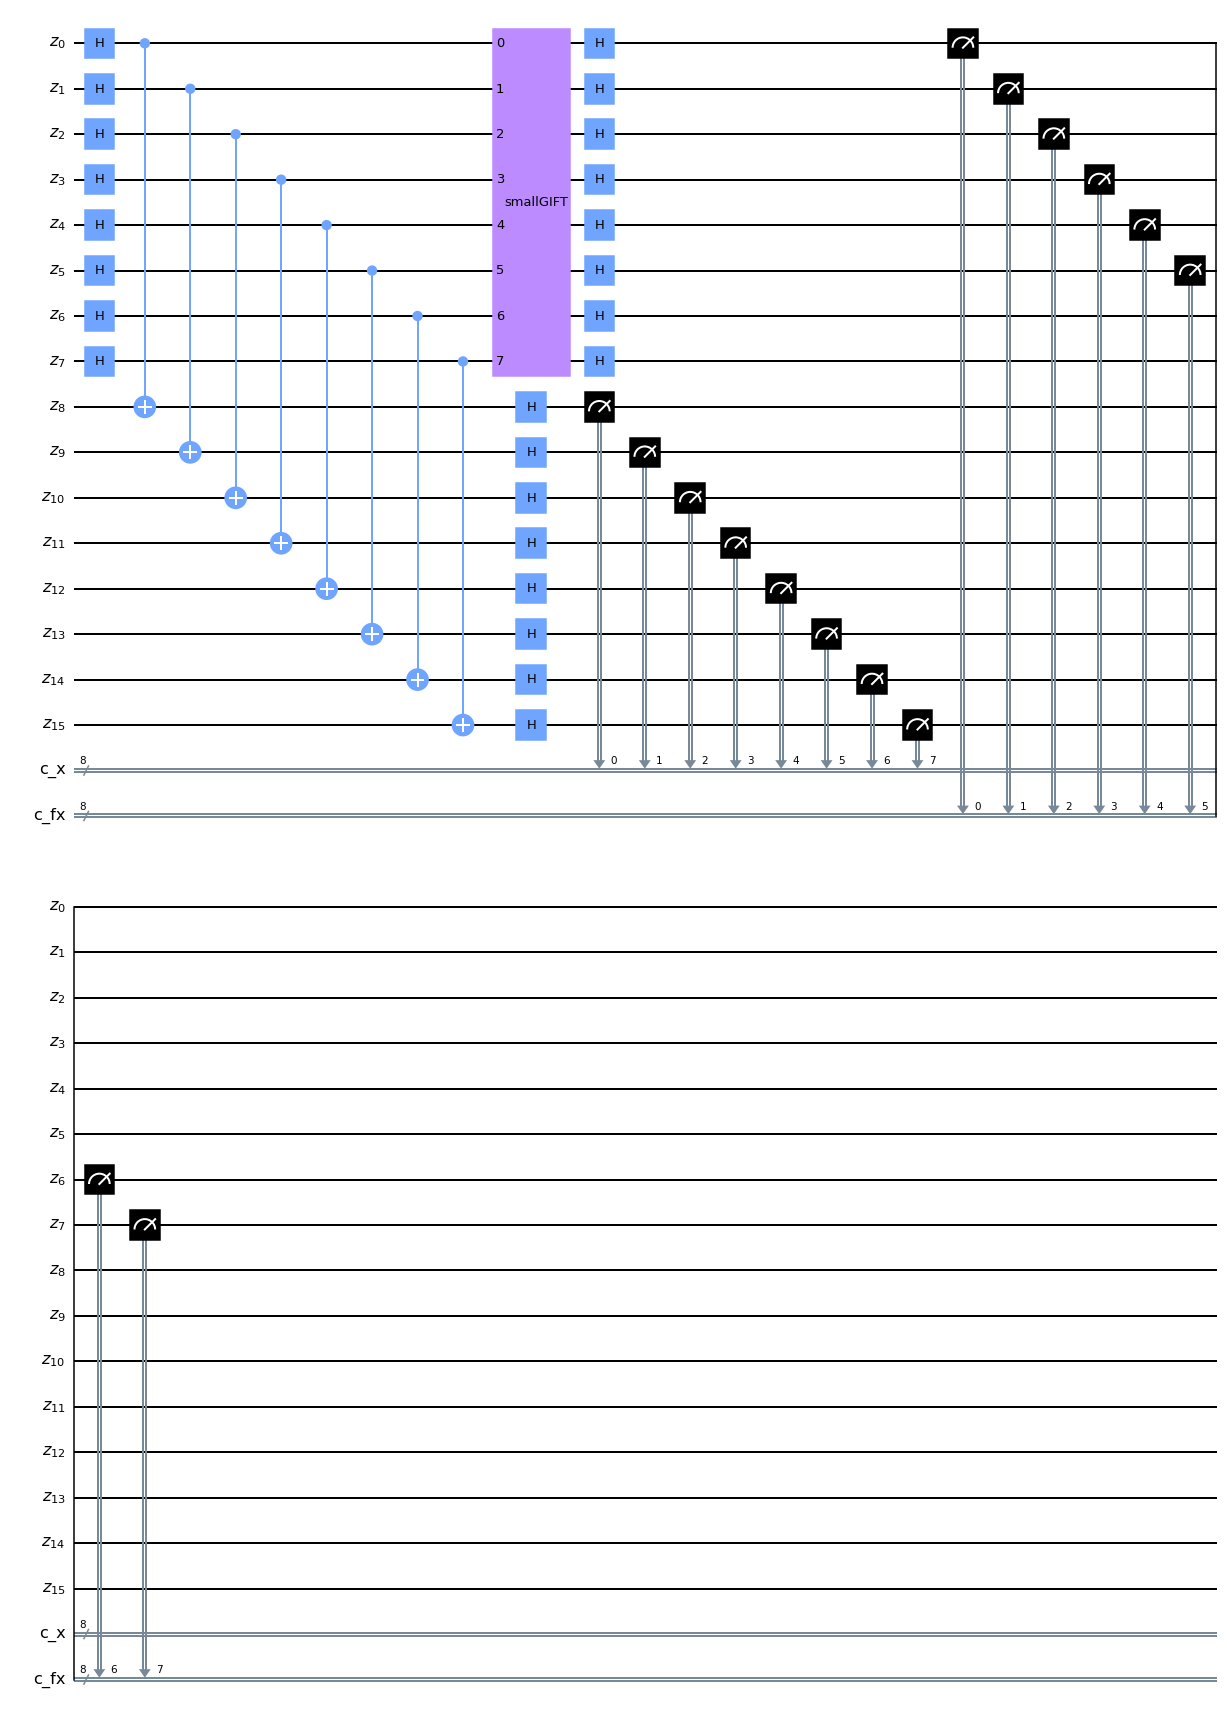

In [136]:
qreg_z = QuantumRegister(block_size*2, 'z')   #z= x, f(x)

creg_c_x = ClassicalRegister(block_size, 'c_x')
creg_c_fx = ClassicalRegister(block_size, 'c_fx')
circuit = QuantumCircuit(qreg_z, creg_c_x, creg_c_fx)

# superposition over subspace of Z
circuit.append(oracle_smallGIFT(block_size), range(0, block_size*2))

# hadamard
circuit.h(range(block_size*2))

circuit.measure(qreg_z[0:block_size], creg_c_fx)
circuit.measure(qreg_z[block_size:block_size*2], creg_c_x)
# circuit_drawer(circuit, output='mpl')
circuit.decompose(gates_to_decompose='oracle_smallGIFT_distribution').draw(output='mpl')
# the structure now is.... |c> |F(x)> |x>

In [ ]:
# circuit_drawer(circuit, output='mpl')

In [19]:
# provider=IBMQ.get_provider('ibm-q')
# backend = provider.get_backend('simulator_mps')

# transpiled = transpile(circuit, backend=backend)

# job = execute(transpiled, backend, shots=10);

# job_monitor(job)

10 min = 500 shots  
14 min = 1000 shots  

In [20]:
# result = job.result()
# counts = result.get_counts()
# counts

In [ ]:
# if using local simulator

# simulator = AerSimulator(method='matrix_product_state')  
simulator=Aer.get_backend('aer_simulator_matrix_product_state')
# simulator = AerSimulator(method='statevector')

# Run and get counts, using the matrix_product_state method
tcirc = transpile(circuit, simulator)
# n_shots=1024
result = simulator.run(tcirc, shots=102400).result()
counts = result.get_counts(0)

In [ ]:
counts

{'01100110 11100101': 1,
 '11010111 00011011': 1,
 '11001001 11011011': 1,
 '01101010 10101101': 1,
 '11111111 10000110': 1,
 '11101101 11111110': 1,
 '10111110 01110110': 1,
 '11001111 11100110': 1,
 '00100011 10111101': 1,
 '10100111 11100001': 1,
 '11011110 11101011': 1,
 '11001101 00010010': 1,
 '11100001 01110010': 1,
 '10000110 10111010': 1,
 '11100110 01011001': 1,
 '10110010 10100101': 2,
 '11101011 11010101': 1,
 '10110110 00100010': 1,
 '11000100 11011111': 1,
 '01111001 00011101': 1,
 '11010111 01101011': 1,
 '01110110 10010001': 1,
 '01111100 01010011': 1,
 '11000011 10101011': 1,
 '11010001 01010011': 1,
 '01110011 11010101': 2,
 '10000110 00110111': 1,
 '11001011 10010010': 1,
 '11000100 00111011': 1,
 '11011011 00100011': 1,
 '10101111 11110110': 1,
 '11100100 00011010': 1,
 '11011101 10110110': 1,
 '01101100 11011011': 1,
 '10011110 11110011': 1,
 '11010000 10011011': 1,
 '01101000 01111011': 1,
 '01110111 01010111': 1,
 '01000111 10011101': 1,
 '10010111 11111011': 2,


In [119]:
key_list = ["{:04x}".format(int(x.split()[0],2))+" "+"{:04x}".format(int(x.split()[1],2)) for x in counts.keys()]
final_counts = dict(zip(key_list, list(counts.values())))

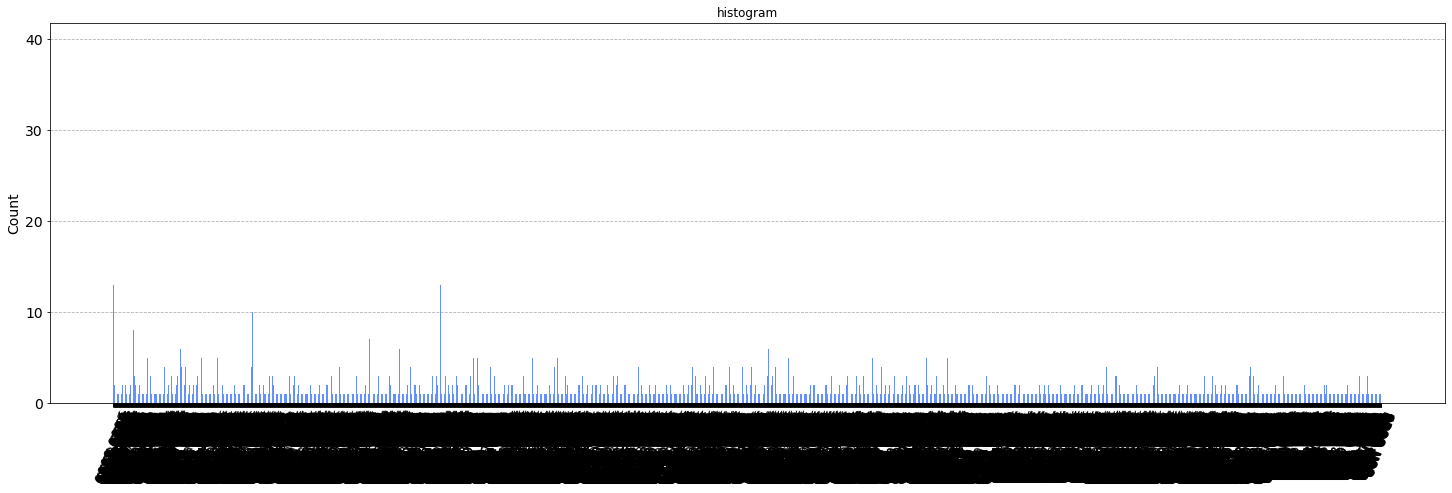

In [120]:
fig, ax = plt.subplots(figsize =(25, 7))
plot_histogram([final_counts], title="histogram", bar_labels=False, ax=ax)

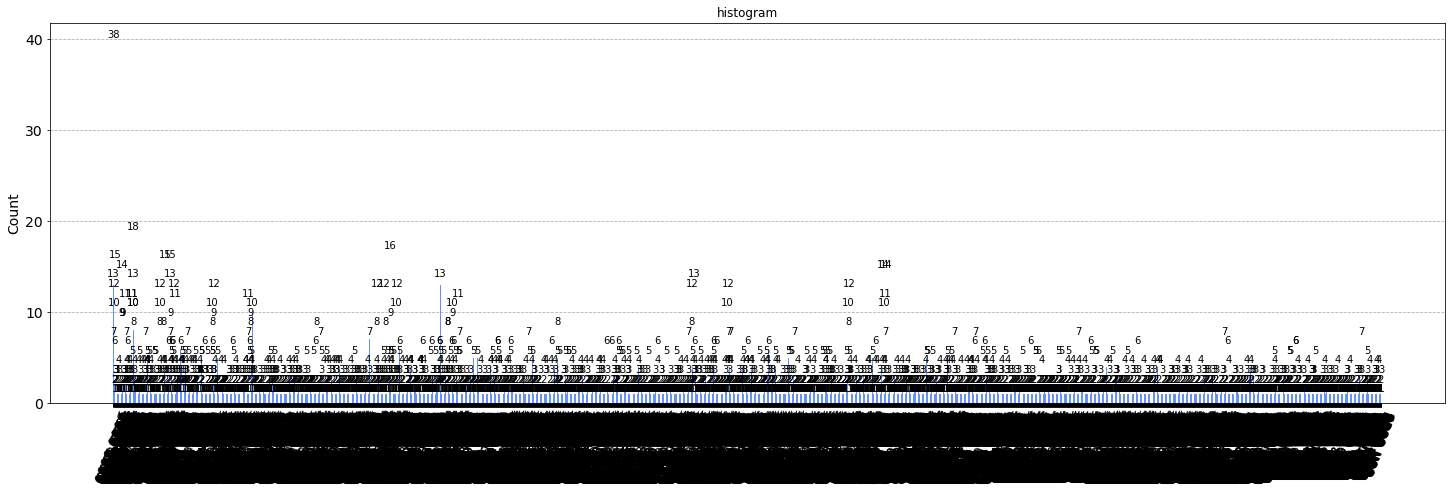

In [128]:
fig, ax = plt.subplots(figsize =(25, 7))
plot_histogram([final_counts], title="histogram", bar_labels=True, ax=ax)

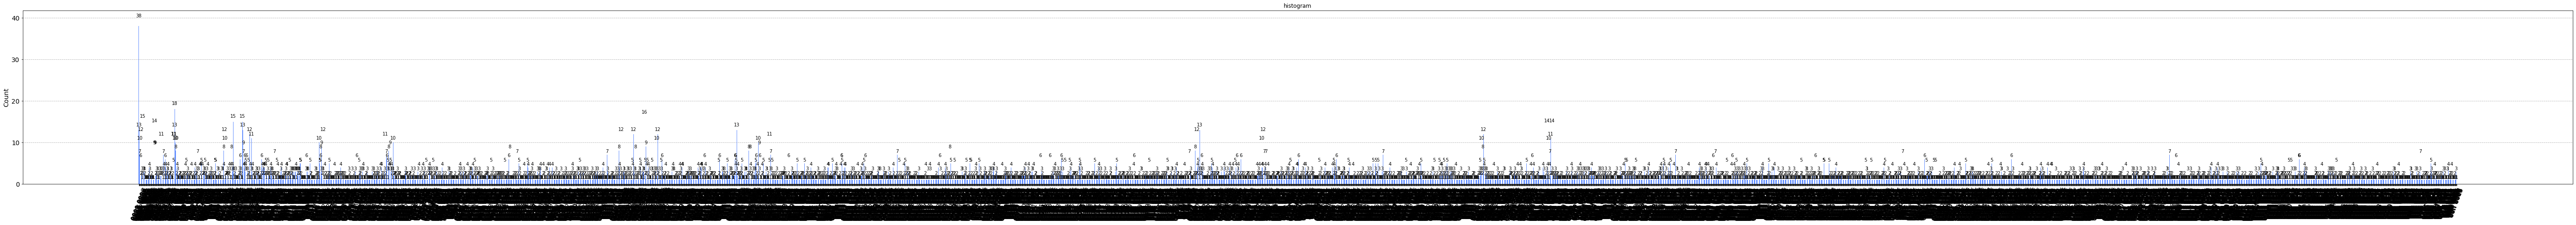

In [130]:
fig, ax = plt.subplots(figsize =(100, 7))
plot_histogram([final_counts], title="histogram", bar_labels=True, ax=ax)
fig.savefig('pqrs2.svg')

In [113]:
a=dict((k, v) for k, v in counts.items() if v >= 8)
a

{'00010000 10100000': 8,
 '10100001 00000011': 8,
 '00101000 00000100': 11,
 '01000110 00110000': 10,
 '00001000 00001100': 11,
 '00010010 01010000': 8,
 '10101000 00000100': 14,
 '00000001 00001110': 10,
 '00101010 00011010': 10,
 '10101001 00000100': 11,
 '01010100 10000000': 9,
 '00010100 00100000': 15,
 '00000010 00010000': 12,
 '01010000 10100000': 13,
 '00000010 10010000': 15,
 '01010010 10110000': 8,
 '00100001 00000010': 9,
 '01010110 01000000': 11,
 '01010010 01000000': 8,
 '00001001 00000111': 10,
 '10000001 00000101': 13,
 '01000000 01100000': 8,
 '00000100 11000000': 9,
 '00000100 11100000': 9,
 '01000000 11100000': 12,
 '10100001 00001000': 12,
 '00010000 11010000': 10,
 '01010100 01000000': 10,
 '00010110 00010000': 12,
 '10101000 00001011': 10,
 '10000000 00001001': 12,
 '00001000 00001101': 13,
 '00000100 11110000': 9,
 '10100000 00001111': 10,
 '00000001 00001100': 13,
 '10001000 00000101': 10,
 '00100000 00000110': 10,
 '00101001 00000100': 8,
 '01000010 11110000': 8,

In [114]:
key_list = ["{:04x}".format(int(x.split()[0],2))+" "+"{:04x}".format(int(x.split()[1],2)) for x in a.keys()]
final_a = dict(zip(key_list, list(a.values())))
# final_a

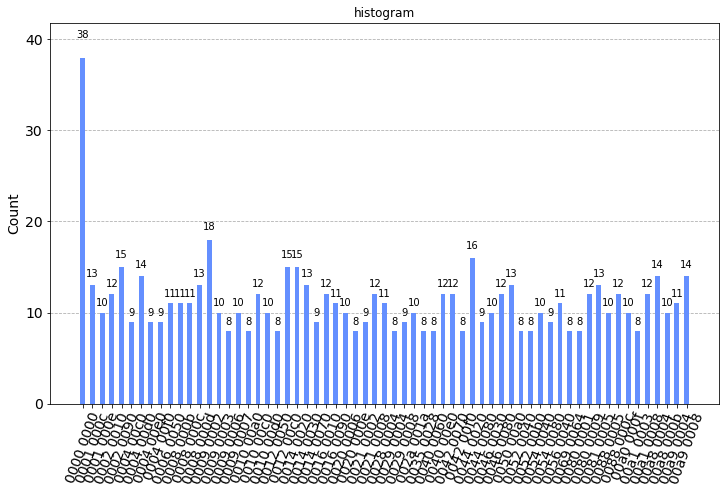

In [121]:
fig, ax = plt.subplots(figsize =(12, 7))
plot_histogram([final_a], title="histogram", bar_labels=True, ax=ax)

In [68]:
from matplotlib import pyplot as plt

(array([599., 599., 599., 599., 598., 599., 599., 599., 599., 599.]),
 array([   0. ,  598.8, 1197.6, 1796.4, 2395.2, 2994. , 3592.8, 4191.6,
        4790.4, 5389.2, 5988. ]),
 <BarContainer object of 10 artists>)

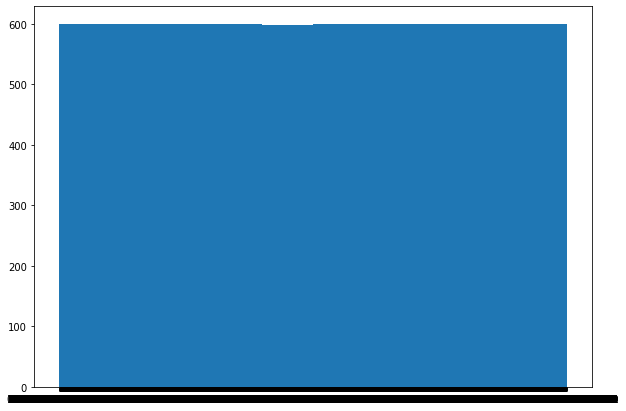

In [69]:
# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(counts)

In [ ]:
qreg_c = QuantumRegister(block_size*2, 'c')
qreg_z = QuantumRegister(block_size*2, 'z')
qreg_t = QuantumRegister(1, 'target')

creg_c = ClassicalRegister(block_size*2, 'c_m')
creg_t = ClassicalRegister(1, 'target_m')
circuit = QuantumCircuit(qreg_c,qreg_z, qreg_t, creg_c, creg_t)


# all C in superposition
circuit.h(range(block_size*2))
  
# superposition over subspace of Z
circuit.append(oracle_smallGIFT(block_size), range(block_size*2, block_size*4))

for i in range(block_size*2):
  circuit.ccx(qreg_c[i], qreg_z[i], qreg_t)

circuit.z(qreg_t)

circuit.append(oracle_smallGIFT(block_size).inverse(), range(block_size*2, block_size*4))

circuit.h(range(block_size*3, block_size*))


for i in range(block_size*2):
  circuit.measure(qreg_c[i], creg_c[i])



circuit.measure(qreg_t, creg_t)

# circuit_drawer(circuit, output='mpl')
circuit.decompose(gates_to_decompose='oracle_smallGIFT_distribution').draw(output='mpl')
# the structure now is.... |c> |F(x)> |x>